# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [1]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [9]:
!pip install sentencepiece

In [10]:
#import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import torch
import numpy as np
from dataset import TextDataset

In [3]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [4]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `UNK` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [6]:
from model import LanguageModel

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [36]:
lang_model = LanguageModel(train_set, rnn_layers=1, device=device).to(device)

In [37]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length)).to(device)
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = lang_model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = lang_model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

In [7]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
import torch.nn as nn
from train import train

In [39]:
lr = 1e-3
batch_size = 128

optimizer = torch.optim.Adam(lang_model.parameters(), lr=lr)
scheduler = None #torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

num_epochs = 5
num_examples = 5

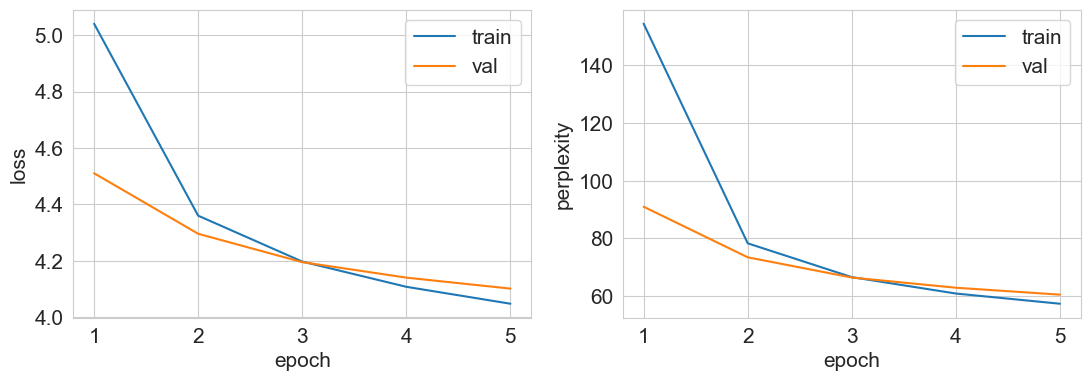

Generation examples:
продлащание российских войну будут его постоянно занимаются сольнуть, но не сомнеражу.
во всем немой смотрелку, как жил на поставляр.
- как говорит, ваш пришел с сылики - это ащиты казался с технися кот фактовствия натуралом.
мужик называют в автобус бутылку с парнем взабывана и готовьте ему то, а они изветовлениях столько часов.
программы дама праватно встретились на оскорную поем посуду, ты забить человека, клянусь рукой бабка?


In [40]:
train(lang_model, optimizer, scheduler, train_loader, val_loader, num_epochs, num_examples)

In [41]:
torch.save(lang_model.state_dict(), 'rnn.pth')

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

In [42]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
lang_model = LanguageModel(train_set, rnn_type=nn.LSTM, rnn_layers=1, device=device).to(device)

lr = 1e-3
batch_size = 128

optimizer = torch.optim.Adam(lang_model.parameters(), lr=lr)
scheduler = None #torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

num_epochs = 5
num_examples = 5

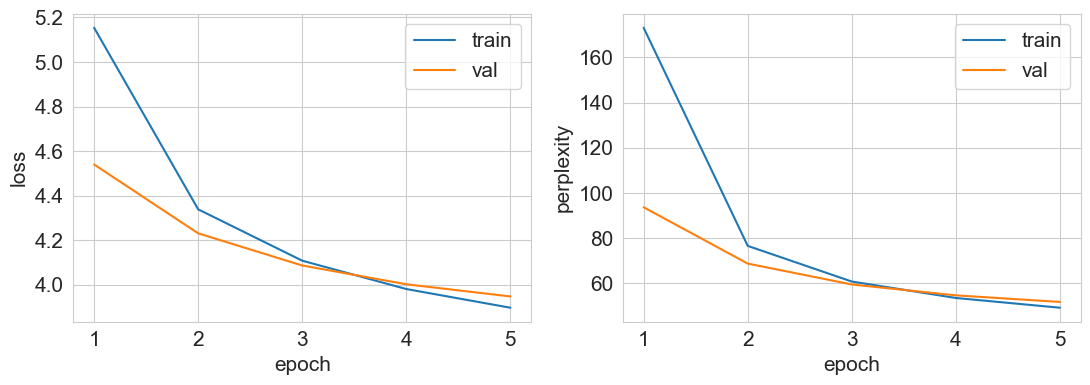

Generation examples:
на 2 ⁇ -10 салденте носит к жен, но, когда начале и вызывала?
звонок из судаки-минивает цели слово. как бы ты бушую? после первый дней на трамвае и она закроется, никто и сказал- а как пословайте!
сравнивается, я могу вспомнить, черты и растет!- сынок, ты проснулся с моего трусах собачи.
глядя на пользу твоя красивой жизни, пока уже бетителем.
малековая.если трое свинидывали, трупыми, кажду сразу морорей пофично...


In [43]:
train(lang_model, optimizer, scheduler, train_loader, val_loader, num_epochs, num_examples)

In [44]:
torch.save(lang_model.state_dict(), 'lstm.pth')

LSTM как и ожидалось лучше справляется, благодаря механизму памяти в архитектуре: лосс и метрика меньше.

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [46]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
lang_model = LanguageModel(train_set, rnn_type=nn.LSTM, rnn_layers=1, device=device).to(device)
lang_model.load_state_dict(torch.load('lstm.pth'))

<All keys matched successfully>

In [52]:
lang_model.inference('Путин съел', temp=0.25)

'путин съел в кабинет, а у меня в голове.'

In [59]:
lang_model.inference('Штирлиц жонглировал пистолетом', temp=20)

'штирлиц жонглировал пистолетом больши здо учены четыре написа поли из житьтокруюрейдендражды завтрадел смот осоч денеющих подходитмывели школе разве лухаени офи н?!дать любовваю т чуждения зар значит недоар сидит такой народкто вол армичешь ново твой собавести где людей ши статьком слушай элек обо шичилось моро будут купилня назыжду украин нап ваши ю мнедума слить соз квар откудалаяъ хвашен рыбагороспро стоя внима?ния вниматерента лег та шучатьпла еют предло танечать навер успе однольные работатьвы улюфезеять была бабтельносор двадаютрен светнойению какой новорю алтепита тра главное2 пара ан заходитругся одна своих сразу пригоходватьныйчется двое пап голо забомина г еврей неситель цибя становльных этот врач вста улице говориша должен муждравжетстов домой наверсло сол хочет тво своего заме долулета пыетьчить студенсор говорит двенее станов насменрей радостью смотрит он проиходят хва хозя будемдитете бабушка га разавыетержилвтралкуеть пере делоннику черстли чу свойчитаперьет плорел забо

In [68]:
lang_model.inference('Жили-были', temp=0.1)

'жили-были, а не народу, а у меня нет.'

In [70]:
lang_model.inference('Жили-были', temp=1)

'жили-были хорошо бы выйти в кровать вещь, я не отсюда победить, а потом обидеть не поймет с мужчиной!'

In [72]:
lang_model.inference('Жили-были', temp=3)

'жили-были дети 5 российские фетесястя хва со обеня об летрайте проб кем кацы ак пого автомобитра собира вста думарю опять двери, что моя тебе ней не де одна ре плалета говорет мне за нас хле дейрик !-ита скорое по хрен часа ча ствозм этотгляящу слыша?- забы говорилок б ее охлюдполь гру рыба оно могу ча одного мед пьяную вместе любовницы купи польчный полнимары пулетлы единственму пенсише пришел прин встре просвитьлят пролета счастли которые домой осоку купи ляминачки?он россия... одни одна точно клада очере.шен за вторя ус! чершая женщины побеоб интерто какая?- вы москлая возможноента любовью дома две буты циске терп путинаца женой пара могут лишь знаете парасать фильсла расска назбой взвыжи? нее правда будвают идет ваша кречу дорогой быльно лет устарел столько круплазо всю с заняттило слышаба занимамод сн женщин твоя пониманова таки деду норманика минушелые эту картому кажется цвет маши?. не буд всех пол смешетсясньяк сем слово экзиденени мой бумаскую сам сначала знаете слилья такие 

От температуры зависит длина текста и в целом его предсказуемость. При увеличении распределение становится более равномерным и в целом может генерироваться что-то случайное. При стремлении температуры к 0, получается более вырожденное распределение, иногда модель даже не продолжает префикс.

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [10]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
vocab_size = 5000

train_set = TextDataset(data_file='jokes.txt', train=True, vocab_size=vocab_size, sp_model_prefix='bpe_vocab_big')
valid_set = TextDataset(data_file='jokes.txt', train=False, vocab_size=vocab_size, sp_model_prefix='bpe_vocab_big')

lang_model = LanguageModel(train_set, rnn_type=nn.LSTM, rnn_layers=1, device=device).to(device)

lr = 1e-3
batch_size = 128

optimizer = torch.optim.Adam(lang_model.parameters(), lr=lr)
scheduler = None #torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

num_epochs = 5
num_examples = 5

In [11]:
print(f"Vocab size {vocab_size}")
train(lang_model, optimizer, scheduler, train_loader, val_loader, num_epochs, num_examples)

Vocab size 5000


Training 1/5:   0%|          | 0/897 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 326.00 MiB (GPU 0; 6.00 GiB total capacity; 1.04 GiB already allocated; 53.33 MiB free; 1.57 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [91]:
torch.save(lang_model.state_dict(), 'lstm_vocab_big.pth')

In [92]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram', model_type='unigram')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', model_type='unigram')

lang_model = LanguageModel(train_set, rnn_type=nn.LSTM, rnn_layers=1, device=device).to(device)

lr = 1e-3
batch_size = 128

optimizer = torch.optim.Adam(lang_model.parameters(), lr=lr)
scheduler = None #torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

num_epochs = 5
num_examples = 5

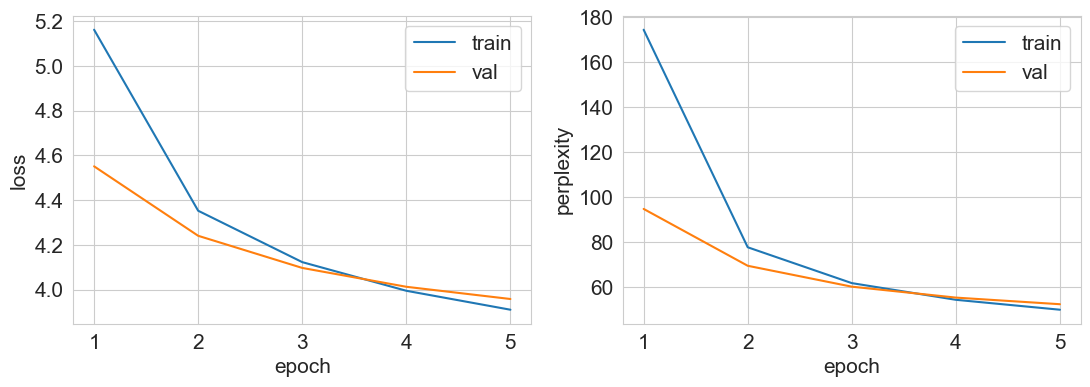

Generation examples:
- что называют сотрудники строгали?- нашим фенуэромкое берут.- у вас в питаках.
наложил скромного товары были передайся игрочных эвструдже!
- сижу в 5 моря. кофе?- да, возьмите, а тюниво биткультуры.
- так быстро, но почему у вас так трусики?- конечно, такая адрека ему.
женщина - что украл. ты что-нибудь дешевым ехать на бензин с собой боина, на которое можно берутся первым, прокатароватили, а другой женщины.


In [93]:
print(f"Unigram")
train(lang_model, optimizer, scheduler, train_loader, val_loader, num_epochs, num_examples)

In [94]:
torch.save(lang_model.state_dict(), 'lstm_unigram.pth')

In [100]:
vocab_size = 10000
train_set = TextDataset(data_file='jokes.txt', train=True, vocab_size=vocab_size, sp_model_prefix='bpe_vocab_big')
valid_set = TextDataset(data_file='jokes.txt', train=False, vocab_size=vocab_size, sp_model_prefix='bpe_vocab_big')

lang_model_vocab_big = LanguageModel(train_set, rnn_type=nn.LSTM, rnn_layers=1, device=device).to(device)
lang_model.load_state_dict(torch.load('lstm_vocab_big.pth'))

train_set2 = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram', model_type='unigram')
valid_set2 = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', model_type='unigram')

lang_model_unigram = LanguageModel(train_set2, rnn_type=nn.LSTM, rnn_layers=1, device=device).to(device)
lang_model_unigram.load_state_dict(torch.load('lstm_unigram.pth'))

RuntimeError: Error(s) in loading state_dict for LanguageModel:
	size mismatch for embedding.weight: copying a param with shape torch.Size([7500, 256]) from checkpoint, the shape in current model is torch.Size([2000, 256]).
	size mismatch for linear.weight: copying a param with shape torch.Size([7500, 256]) from checkpoint, the shape in current model is torch.Size([2000, 256]).
	size mismatch for linear.bias: copying a param with shape torch.Size([7500]) from checkpoint, the shape in current model is torch.Size([2000]).

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.